## Modeling
- NOTE: r/xboxone = Xbox | r/PS4 = PS

In [1]:
#Imported Libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

---

### Data Setup
The following set of codes will prepare the data for the modeling process. Steps are as follows: 
- Load data and isolate the desired columns: I decided to only the text column for the modeling since it combines both the selftext and title.
- Split data into X (predictor) and y (target/response) variables 
- Identify baseline score 
- Establish a function that calculates the metric of interest

In [2]:
#Read data and isolate desired columns 
combine = pd.read_csv("../datasets/cleaned_data.csv")
combine = combine[['subreddit', 'text']]

#Set X (predictor) and y (target)variables 
X = combine['text']
y = combine['subreddit'] 

#Split data
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

#Establish stopword list
my_stop_words = text.ENGLISH_STOP_WORDS.union(['playstation'])

#Define Baseline Score
y_test.value_counts(normalize=True)

0    0.503604
1    0.496396
Name: subreddit, dtype: float64

**Baseline Score:** My baseline score for this project is 50%.

**Metrics Selection:** To evaluate how well my models are performing, I decided to measure the following metrics: accuracy, sensitivity, and specificity. The reasoning behind this is that I am interested in understanding what proportion of my results is incorrectly categorized. 
- Specificity: measures the correctness of predicting posts from the Xbox subreddit. 
- Sensitivity: measures the correctness of predicting post from the PS subreddit.

In [4]:
def metrics(model):
    '''Takes in a model and returns metrics'''
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    cv_score = model.best_score_
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    print(f' Train accuracy: {train_score}\n Test accuracy: {test_score}\n Best accuracy: {cv_score}\n Specificity:\
    {specificity}\n Sensitivity: {sensitivity}')

---

### Model 1: CountVectorizer and MultiNomial Naive Bayes
I decided to do a MultiNomial Naive Bayes model because it is suitable for classification with discrete features (i.e., word counts from text). Also, it relies on prior knowledge to calculate probabilities. For this project, the model's goal is to learn the likelihood of a word existing in either subreddits. Additionally, it has a `.coef_` attribute making the coefficients interpretable, which allows for isolating game titles that have the highest impact in the modeling process.  

In [8]:
#Set pipeline
pipe = Pipeline([('cvec', CountVectorizer(stop_words=my_stop_words)), 
               ('nb', MultinomialNB())
                ])

#Define alpha
alpha = np.logspace(-3,3,10)

#Set pipeline parameters 
pipe_params = { 
              'cvec__max_df': [0.80, 0.90], 
              'cvec__max_features': [7000], 
              'cvec__min_df': [5],
              'cvec__ngram_range': [(1,2)],
              'nb__alpha': alpha}

#Intantiate GridSearch and fit to training data
gs_cvec_nb = GridSearchCV(pipe, pipe_params, cv=5)
gs_cvec_nb.fit(X_train, y_train)

print(metrics(gs_cvec_nb))
gs_cvec_nb.best_params_

 Train accuracy: 0.7895053074304026
 Test accuracy: 0.7330796956347617
 Best accuracy: 0.7256829027462326
 Specificity:    0.7598409542743538
 Sensitivity: 0.7059298104074223
None


{'cvec__max_df': 0.8,
 'cvec__max_features': 7000,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 2),
 'nb__alpha': 0.1}

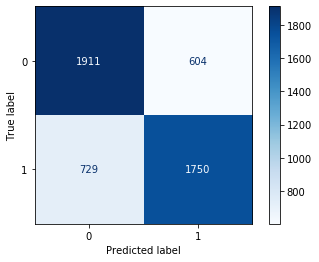

In [9]:
plot_confusion_matrix(gs_cvec_nb, X_test, y_test, cmap='Blues', values_format='d');

**Findings:** My model has an accuracy of 73%, where it correctly predicted 71% of PS subreddit posts and 76% of Xbox posts. However, it is overfitting, as seen by the vast gap between the test and training accuracy scores. To try to resolve this issue, I tried a different vectorizer (TfidVectorizer). 

---

### Model 2: TfidfVectorizer and MultinomialNB

As previously mentioned, the vectorizer is changed to see if it will improve the model's overfitting problem.

In [10]:
#Set pipeline
pipe2 = Pipeline([('tf', TfidfVectorizer(stop_words=my_stop_words)), 
               ('nb', MultinomialNB())
                ])

#Define alpha
alpha = np.logspace(-3,3,10)

#Set pipeline parameters 
pipe_params2 = {
               'tf__max_df': [0.50],
               'tf__max_features': [5100],
               'tf__min_df': [4,5],
               'tf__ngram_range': [(1,2)],
               'nb__alpha': alpha
               }

#Intantiate GridSearch and fit to training data
gs_tf_nb = GridSearchCV(pipe2, pipe_params2, cv=5, n_jobs=2)
gs_tf_nb.fit(X_train, y_train)

print(metrics(gs_tf_nb))
gs_tf_nb.best_params_

 Train accuracy: 0.8119367113959544
 Test accuracy: 0.7392871445734882
 Best accuracy: 0.739501884538316
 Specificity:    0.7510934393638171
 Sensitivity: 0.72730939895119
None


{'nb__alpha': 0.1,
 'tf__max_df': 0.5,
 'tf__max_features': 5100,
 'tf__min_df': 4,
 'tf__ngram_range': (1, 2)}

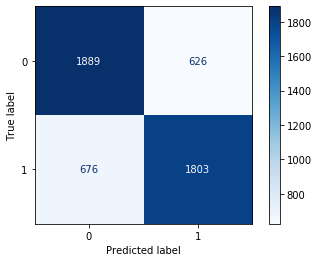

In [11]:
plot_confusion_matrix(gs_tf_nb, X_test, y_test, cmap='Blues', values_format='d');

**Findings:** This model performs at the same rate as the previous with a 74% accuracy. It correctly predicted 73% of PS posts and 75% of Xbox posts. Similar to the previous model, the model is still suffering from overfitting. To ratify the situation, I decided to use a different model (Random Forest Classifier). Although it is also prone to overfitting, its bagging properties should reduce the gap between the training and testing accuracy. 

--- 

### Model 3: TfidVectorizer and Random Forest Classifier

Like the Multinomial Naive Bayes, Random Forest is a white-box model. Its attribute `feature_importance_` allows for the interpretability of its features. As mentioned above, the reason why this model is selected is due to it being an ensemble model that will hopefully reduce the gap between the training and testing accuracy. 

In [12]:
#Set pipeline
pipe3 = Pipeline([('tf', TfidfVectorizer(stop_words=my_stop_words)), 
               ('rf', RandomForestClassifier())
                ])

#Set pipeline parameters 
pipe_params3 = {'tf__max_df': [0.70],
               'tf__max_features': [None,5000],
               'tf__min_df': [2],
               'tf__ngram_range': [(1,2)],
               'rf__max_depth': [10],
               'rf__n_estimators': [150,160]}

#Intantiate GridSearch and fit to training data
gs_tf_rf = GridSearchCV(pipe3, pipe_params3, cv=5, n_jobs= 3)
gs_tf_rf.fit(X_train, y_train)

print(metrics(gs_tf_rf))
gs_tf_rf.best_params_

 Train accuracy: 0.7696107884371454
 Test accuracy: 0.7174609531437726
 Best accuracy: 0.7110629420195208
 Specificity:    0.7101391650099403
 Sensitivity: 0.7248890681726503
None


{'rf__max_depth': 10,
 'rf__n_estimators': 150,
 'tf__max_df': 0.7,
 'tf__max_features': None,
 'tf__min_df': 2,
 'tf__ngram_range': (1, 2)}

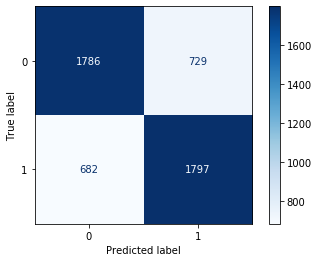

In [13]:
plot_confusion_matrix(gs_tf_rf, X_test, y_test, cmap='Blues', values_format='d');

**Findings:** Unfortunately, this model is doing worst than the Naive Hayes model with an accuracy of 72%. It correctly predicted 72% of PS posts while 71% of Xbox. However, unlike the Naive Hayes, it is less overfitting. 

--- 

### Model 4: TfidfVectorizer and Logistic Regression

Since the Random Forest Classifier is doing worse than the Naive Bayes, I decided to use a Logistic Regression. Similar to the two other models, it is a white-box model with great coefficient interpretability. Additionally, unlike Random Forest, this classifier is easy to regularize and is less prone to overfitting. 

In [5]:
#Set pipeline
pipe4 = Pipeline([('tf', TfidfVectorizer(stop_words=my_stop_words)), 
               ('logreg', LogisticRegression())
                ])

#Set pipeline parameters
pipe_params4 = {'tf__max_df': [0.50],
               'tf__max_features': [5100],
               'tf__min_df': [3],
               'tf__ngram_range': [(1,3)],
               'logreg__C': [0.001, 0.01, 0.10, 1.0],
               }

#Intantiate GridSearch and fit to training data
gs_tf_logreg = GridSearchCV(pipe4, pipe_params4, cv=5)
gs_tf_logreg.fit(X_train, y_train)

print(metrics(gs_tf_logreg))
gs_tf_logreg.best_params_

 Train accuracy: 0.8291608251552173
 Test accuracy: 0.73668402082499
 Best accuracy: 0.7387678841683181
 Specificity:    0.7256461232604374
 Sensitivity: 0.7478822105687777
None


{'logreg__C': 1.0,
 'tf__max_df': 0.5,
 'tf__max_features': 5100,
 'tf__min_df': 3,
 'tf__ngram_range': (1, 3)}

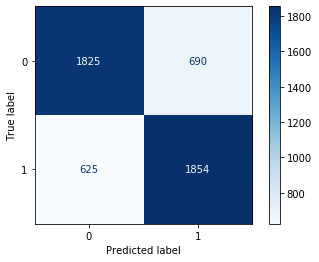

In [6]:
plot_confusion_matrix(gs_tf_logreg, X_test, y_test, cmap='Blues', values_format='d');

**Findings:** The Logistic Regression model performs about the same as the Multinomial Naive Bayes with approximately similar accuracy scores at 74%. It correctly predict 75% of PS posts and 73% of Xbox. Since almost all the models perform similarily,  I decided to use the Logistic Regression since I am more accustomed to interpreting its coefficients. For this project, I am interested in the terms that clearly define the subreddit groups (i.e., features with the highest (PS) and lowest coefficient (Xbox). However, in the future, to address the overfitting issue a more sophisticated ensemble model can be used, such as GradientBoost or XGBoost. 

---

## Results Summary

#### Specificity vs. Sensitivity Summary:

- Logistic Regression and Random Forest's specificity score outperformed sensitivity, while in Naive Bayes, it's the other way around. However, they all still fall within the 70% range, with about 5% difference between models. A possible reason why the model is not doing well in categorizing posts is that both subreddits have very similar content. It is apparent during the word count and top words EDA that the majority of verbiage used is identical.

#### Coefficient Analysis: 

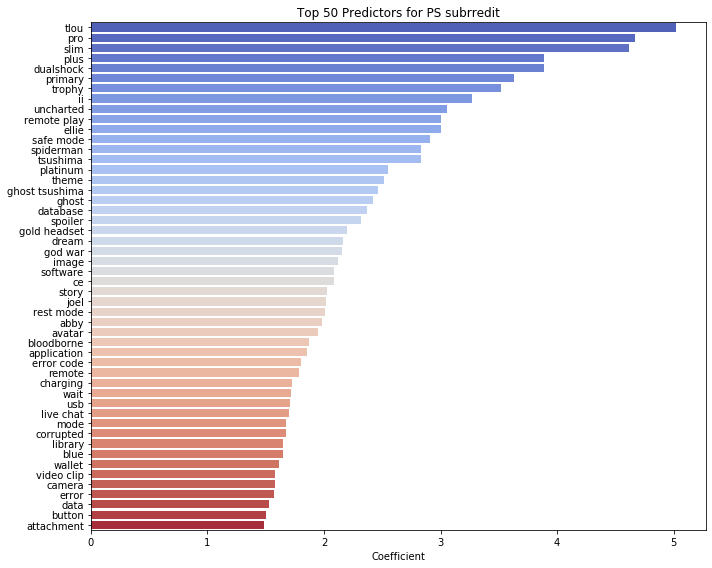

In [13]:
#Isolate coefficient
coefficient = gs_tf_logreg.best_estimator_.steps[1][1].coef_

#Store coefficient and feature names in a sorted data frame
coef_df = pd.DataFrame(coefficient, columns = gs_tf_logreg.best_estimator_.steps[0][1].get_feature_names()).T

#Plot top 50 predictors for PS
plt.figure(figsize=(10, 8))
sns.barplot(y=coef_df.sort_values(0, ascending=False).index[:50], x=coef_df.sort_values(0, ascending=False)[0][:50],
           palette='coolwarm')
plt.title('Top 50 Predictors for PS subrredit')
plt.xlabel('Coefficient')
plt.tight_layout(); 

**Findings:** For the PS subreddit, game titles categorized as great modeling predictors are: TLOU (The Last of Us), Uncharted, Ghost of Tsushima, Spiderman, God of War, and Bloodborne. Interestingly, all games mentioned are PlayStation exclusive games and have an action-adventure genre. Additionally, they are known for their storytelling narrative and visually appealing graphics. A possible hypothesis of Playstation gamer's preference is that they value game exclusivity. Moreover, a powerful story component appeals significantly to that target market. To further support this claim, I cross-reference the six games above to an article published by PS4.com about the top-selling games for Playstation 4. Three out of the six games above (The Last of Us, God of War, and Spiderman) are among the list. This evidence solidifies my hypothesis about Playstation user preference. 

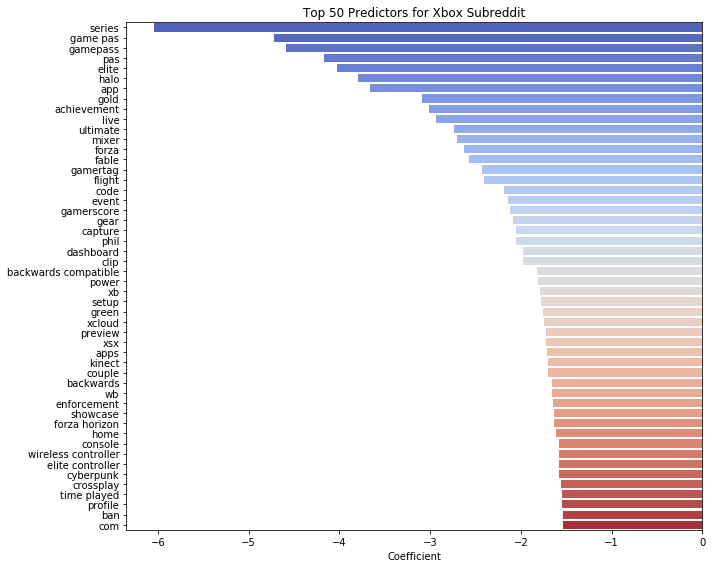

In [14]:
#Plot the top 50 predictors for Xbox
plt.figure(figsize=(10, 8))
sns.barplot(y=coef_df.sort_values(0).index[:50], x=coef_df.sort_values(0)[0][:50],
           palette='coolwarm')
plt.title('Top 50 Predictors for Xbox Subreddit')
plt.xlabel('Coefficient')
plt.tight_layout(); 

**Findings:** For the Xbox subreddit, the titles that stood out are Forza, Halo, Fable, Gears of Wars, and Cyberpunk. An interesting similarity between the games is that all five of them have a robust online community. Secondly, except Cyberpunk, these games are Xbox exclusive games. Therefore, a similar hypothesis can be said about Xbox users, where game exclusivity is essential. However, unlike PS4 gamers, they prefer games with an online presence to play with friends. These observations are further emphasized in the top-selling games for Xbox One, according to Gamespot: Forza, Gears of War, Halo, Call of Duty, and Battlefield. These top-selling games have a commonality of being popular due to their online multiplayer options. 